In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import random
import re
import itertools
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from IPython.core.debugger import set_trace

In [3]:
# logging set-up
import logging
logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                    datefmt='%d/%m/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
# Make deterministic
random.seed(47)
torch.manual_seed(47);

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [6]:
# Enable cuDNN autotuner. This runs a short benchmark and selects the convolution algorithm with the best performance.
torch.backends.cudnn.benchmark = True  

In [7]:
# path = Path('/data/s4314719/image-captioning/')  # set this to the path where the dataset should be stored
# path = Path('/image_data/')  # set this to the path where the dataset should be stored
# path = Path('C:/Users/leann/Documents/Master AI IS/Deep Learning/image_data/')

path.mkdir(exist_ok=True)

In [8]:
img_dir = path/'Flicker8k_Dataset'
ann_file = path/'Flickr8k.token.txt'

In [9]:
URL = 'https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/'
FILENAMES = ['Flickr8k_text.zip', 'Flickr8k_Dataset.zip']

In [10]:
# Download dataset
import requests
from zipfile import ZipFile

for fn in FILENAMES:
    if not (path/fn).exists():  # do not download if the dataset has already been downloaded
        print(f'Downloading {fn}')
        r = requests.get(URL + fn)
        (path/fn).write_bytes(r.content)
        print(f'Extracting files...')
        with ZipFile(path/fn) as zipf:
            zipf.extractall(path)

In [11]:
list(path.glob('*')) # list all files

[PosixPath('/data/s4314719/image-captioning/__MACOSX'),
 PosixPath('/data/s4314719/image-captioning/Flickr_8k.trainImages.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k_Dataset.zip'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k.lemma.token.txt'),
 PosixPath('/data/s4314719/image-captioning/ExpertAnnotations.txt'),
 PosixPath('/data/s4314719/image-captioning/readme.txt'),
 PosixPath('/data/s4314719/image-captioning/Flicker8k_Dataset'),
 PosixPath('/data/s4314719/image-captioning/CrowdFlowerAnnotations.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr_8k.testImages.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k.token.txt'),
 PosixPath('/data/s4314719/image-captioning/Flickr8k_text.zip'),
 PosixPath('/data/s4314719/image-captioning/Flickr_8k.devImages.txt')]

In [12]:
print((path/'Flickr8k.token.txt').read_text()[:696])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .


In [13]:
from torch.utils.data import Dataset, DataLoader
from src.caption_utils import preprocess_tokens
from PIL import Image

class FlickrDataset(Dataset):
    unk_token = '<UNKNOWN>'
    ns_token = '<NOTSET>'
    start_token = '<START>'
    end_token = '<END>'
        
    def __init__(self, img_dir, img_captions_enc, known_words, ann_file, img_ids, split, trnsf=None):
        self.img_dir = Path(img_dir)
        self.known_words = known_words
        self.ann_file = Path(ann_file)
        self.trnsf = trnsf
        self.split = split
        self.annotations = {}
        
        assert self.split in ['train', 'eval', 'test']
        
        #img_captions_enc, self.known_words, _ = preprocess_tokens(ann_file)
        
        # iterate through the annotation file and create (image, caption) pairs
        img_ids = Path(img_ids).read_text().split('\n')
        for i, (img_id, annotation) in enumerate(img_captions_enc):
            if not (img_dir/img_id).exists() or not img_id in img_ids:
                continue
            if img_id in self.annotations:
                img_annotations = self.annotations[img_id]
                img_annotations.append(annotation)
            else:
                img_annotations = [annotation]
            self.annotations.update({img_id: img_annotations})
        self.img_ids = list(self.annotations.keys())
        
    def __len__(self): 
        return len(self.annotations)
    
    def __getitem__(self, idx):
        img_id = self.img_ids[idx]
        img_annotations = self.annotations[img_id]
        if self.split == 'train':
            ann_idx = np.random.randint(0, len(img_annotations) - 1)  # select one of the five annotations at random
        else:
            ann_idx = 0  # select the first annotation for evaluation/testing
        annotation = img_annotations[ann_idx]
        im = Image.open(self.img_dir/img_id)
        if self.trnsf is not None:
            im = self.trnsf(im)
        return im, annotation, self.split
    
    def decode_caption(self, caption):
        res = ''
        for i, word_idx in enumerate(caption):
            word = list(self.known_words.keys())[word_idx]
            res += word
            if word == self.end_token:
                break
            res += ' '
        return res
    
    def encode_caption(self, caption):
        res = []
        for i, word in enumerate(caption):
            if word in known_words:
                # this is not very efficient; can be improved by creating a dictionary of (word, encoding) pairs
                res.append(list(self.known_words.keys()).index(word))
            else:
                res.append(list(self.known_words.keys()).index(self.unk_token))
        return res

### Preprocessing the images

In [14]:
# Calculate mean and standard deviation over all channels for normalization
# mean = torch.cat([ex[0].view(3, -1) for ex in data], 1).mean(1)
# std = torch.cat([ex[0].view(3, -1) for ex in data], 1).std(1)
# mean = np.array([0.4629, 0.4468, 0.4050])
# std = np.array([0.2661, 0.2587, 0.2727])

# normalization data for pretrained PyTorch model
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [15]:
from torchvision import transforms

# We resize the images and center crop them, as in the 'Show, attend and tell' paper. In the paper they
# resize the shortest side to 256 while preserving the aspect ratio, and then apply a center crop to 
# end up with an image of size 224x224. Note that for quick experimentation, we can use a smaller image 
# size (e.g. 128x128) to speed up training. 
trnsf = {
    'train': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'eval': transforms.Compose([
#         transforms.Resize(256),
#         transforms.CenterCrop(224),
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

### Preprocessing the captions

In [16]:
# Calls the preprocessing of the captions which may take a while (progress is printed)
img_captions_enc, known_words, _ = preprocess_tokens(ann_file)
vocab_size = len(known_words)
vocab_size

02/04/2021 08:38:46 - src.caption_utils - INFO - Creating word dictionary: 0/40461
02/04/2021 08:38:47 - src.caption_utils - INFO - Creating word dictionary: 10000/40461
02/04/2021 08:38:48 - src.caption_utils - INFO - Creating word dictionary: 20000/40461
02/04/2021 08:38:50 - src.caption_utils - INFO - Creating word dictionary: 30000/40461
02/04/2021 08:38:51 - src.caption_utils - INFO - Creating word dictionary: 40000/40461
02/04/2021 08:38:51 - src.caption_utils - INFO - Replacing tokens with numerical values: 0/40461
02/04/2021 08:39:00 - src.caption_utils - INFO - Replacing tokens with numerical values: 10000/40461
02/04/2021 08:39:08 - src.caption_utils - INFO - Replacing tokens with numerical values: 20000/40461
02/04/2021 08:39:17 - src.caption_utils - INFO - Replacing tokens with numerical values: 30000/40461
02/04/2021 08:39:25 - src.caption_utils - INFO - Replacing tokens with numerical values: 40000/40461


5223

### Split data up into train and evaluation set

In [17]:
# We use the predefined train/eval splits of Flickr8k
ds_train = FlickrDataset(img_dir, img_captions_enc, known_words, ann_file,
                         path/'Flickr_8k.trainImages.txt', 'train', trnsf=trnsf['train'])
ds_eval = FlickrDataset(img_dir, img_captions_enc, known_words, ann_file,
                        path/'Flickr_8k.devImages.txt', 'eval', trnsf=trnsf['eval'])
len(ds_train), len(ds_eval)

(6000, 1000)

In [18]:
# show an example from the dataset
img, caption, _ = ds_train[0]
# print(img)
print(caption)
print(ds_train.decode_caption(caption))

[2, 4, 41, 20, 120, 65, 4, 195, 2432, 3]
<START> a little girl climbing into a wooden playhouse <END>


### Visualizing the dataset

In [19]:
def imshow(im):
    imnp = im.numpy()
    imnp = imnp * std[:, np.newaxis, np.newaxis] + mean[:, np.newaxis, np.newaxis]  # undo normalization
    imnp = np.clip(imnp, 0, 1)
    imnp = imnp.transpose([1, 2, 0])
    plt.imshow(imnp)

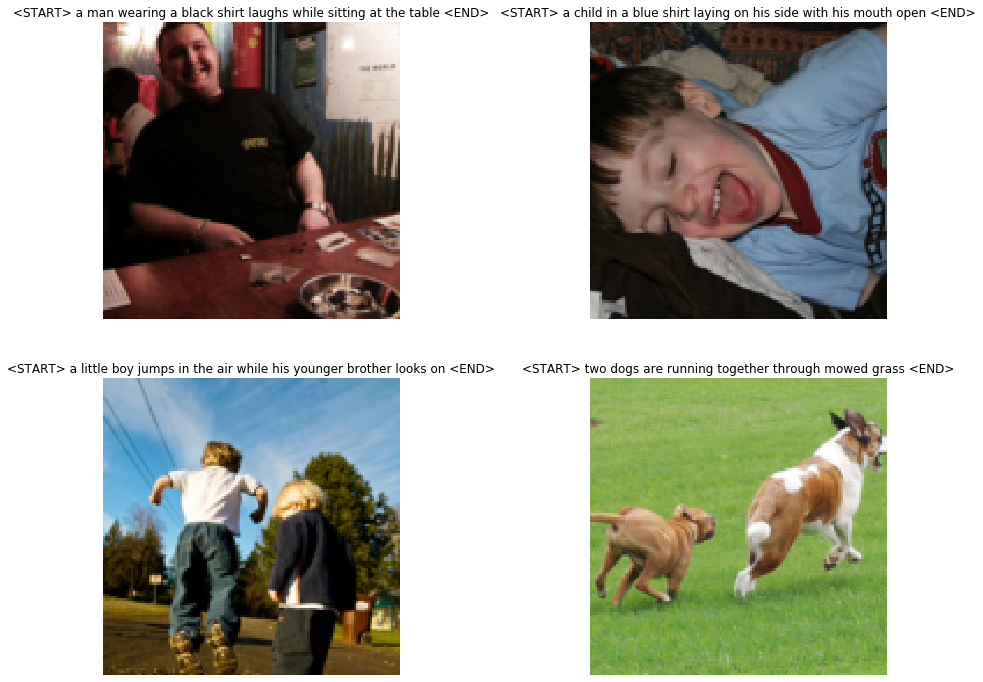

In [20]:
# Plot some examples from the training set
from matplotlib import pyplot as plt

nrows = 2
ncols = 2
plt.figure(figsize=(16, 12))
for i in range(nrows * ncols):
    idx = random.randint(0, len(ds_train)-1)
    im, caption, *_ = ds_train[idx]
    plt.subplot(nrows, ncols, i+1)
    plt.title(ds_train.decode_caption(caption))
    imshow(im)
    plt.axis('off')

In [21]:
# plot the distribution of captions lengths
#caption_lengths = [smpl[2] for smpl in ds_train]  # this takes a while
# plt.hist(caption_lengths)
# plt.title(f'caption lengths, mean = {np.mean(caption_lengths):.1f}')
# plt.xlabel('caption length')
# plt.ylabel('frequency')
# plt.show()

In [37]:
# evalloader = DataLoader(ds_eval, batch_size, shuffle=False, 
#                          num_workers=num_workers, pin_memory=True,
#                          collate_fn=collate_fn)

In [40]:
# it = iter(evalloader)
# batch = next(it)

<START> a black dog carries an orange tennis ball in his mouth as he swims <END>


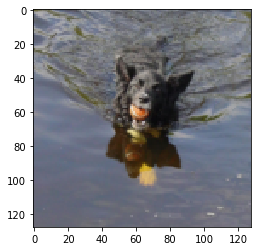

In [41]:
# idx = 15
# imshow(batch[0][idx])
# print(ds_train.decode_caption(batch[2][idx]))

### Model initialization and training

In [29]:
# hyperparameters
num_hidden = 512
embedding_dim = 512
batch_size = 64
epochs = 20
num_workers = 0
num_layers = 1

In [30]:
from src.models import EncoderDecoder, LSTMDecoder, ResNetEncoder

# TODO: this should not be here...
pad_token_idx = list(ds_train.known_words.keys()).index(FlickrDataset.ns_token)
start_token_idx = list(ds_train.known_words.keys()).index(FlickrDataset.start_token)

# encoder = get_encoder(num_hidden)
encoder = ResNetEncoder(num_hidden)
decoder = LSTMDecoder(num_hidden, embedding_dim, vocab_size, pad_token_idx, start_token_idx, num_layers=num_layers)
encoder, decoder = encoder.to(device), decoder.to(device)

model = EncoderDecoder(encoder, decoder, device)
model = model.to(device);

02/04/2021 09:13:53 - src.models - INFO - Number of trainable parameters: 32012455


In [31]:
model

EncoderDecoder(
  (encoder): ResNetEncoder(
    (resnet): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True

In [32]:
optimizer = optim.Adam(model.parameters())
# optimizer = optim.RMSprop(model.parameters(), 0.01)
# optimizer = optim.SGD(model.parameters(), 0.001, momentum=0.9)

In [33]:
# overfit on a mini dataset
ds_train_mini = torch.utils.data.Subset(ds_train, [random.randint(0, len(ds_train) - 1) for _ in range(3)])
ds_eval_mini = torch.utils.data.Subset(ds_eval, [0, 1])

In [35]:
from src.trainer import Trainer, TrainerConfig
from src.utils import collate_fn, make_predictions
from functools import partial

config = TrainerConfig(batch_size=batch_size, epochs=epochs, 
                       num_workers=num_workers, track_grad_norm=False,
                       track_loss=True, track_accuracy=False)
# trainer = Trainer(config, model, optimizer, ds_train_mini, ds_eval_mini,
#                   collate_fn=collate_fn, evaluation_callback_fn=make_predictions)
trainer = Trainer(config, model, optimizer, ds_train, ds_eval, 
                  collate_fn, evaluation_callback_fn=partial(make_predictions, n_predictions=4))

02/04/2021 09:14:50 - src.trainer - INFO - Epoch 0 - train_loss: 4.7261
02/04/2021 09:14:56 - src.trainer - INFO - Epoch 0 - eval_loss: 5.3990 - accuracy: 0.1035


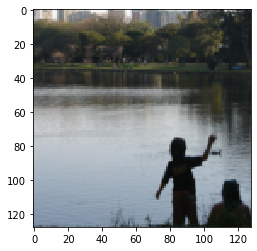

<START> a man in a blue shirt and a black and white dog is running on a red <END>


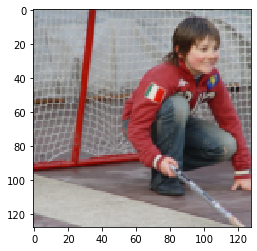

<START> a man in a blue shirt and a black and white dog is running on a red <END>


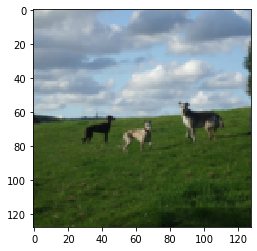

<START> a man in a blue shirt and a black and white dog is running on a red <END>


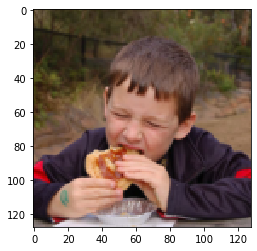

<START> a man in a blue shirt and a black and white dog is running on a red <END>


02/04/2021 09:15:39 - src.trainer - INFO - Epoch 1 - train_loss: 3.6531
02/04/2021 09:15:45 - src.trainer - INFO - Epoch 1 - eval_loss: 5.3261 - accuracy: 0.1213


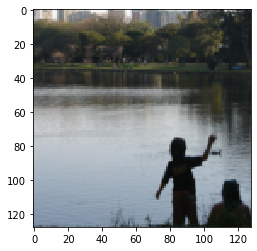

<START> a dog is running through the snow <END>


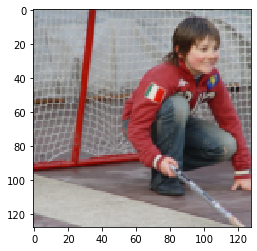

<START> a man in a red shirt is standing on a beach <END>


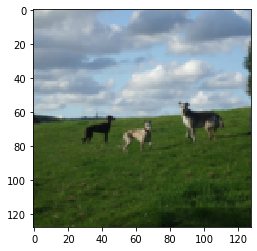

<START> a man in a red shirt is standing on a beach <END>


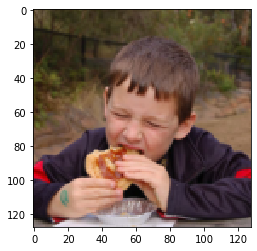

<START> a man in a red shirt is standing on a beach <END>


02/04/2021 09:16:27 - src.trainer - INFO - Epoch 2 - train_loss: 3.4287
02/04/2021 09:16:34 - src.trainer - INFO - Epoch 2 - eval_loss: 5.8635 - accuracy: 0.1068


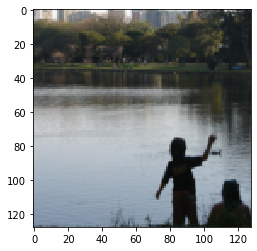

<START> a man in a blue shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white 


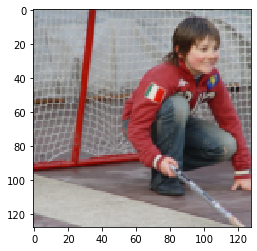

<START> a man in a blue shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white 


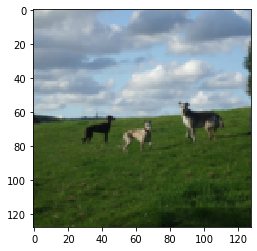

<START> a man in a blue shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white 


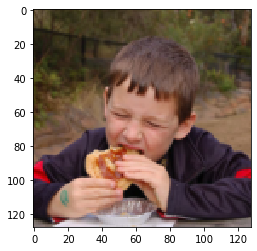

<START> a man in a blue shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white shirt and a white 


02/04/2021 09:17:16 - src.trainer - INFO - Epoch 3 - train_loss: 3.2747
02/04/2021 09:17:23 - src.trainer - INFO - Epoch 3 - eval_loss: 5.7383 - accuracy: 0.1147


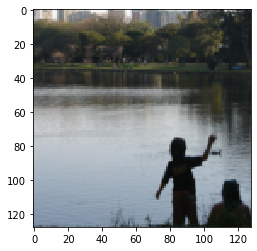

<START> a man is standing on a bench <END>


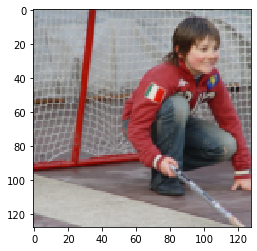

<START> a man in a red shirt is standing on a bench <END>


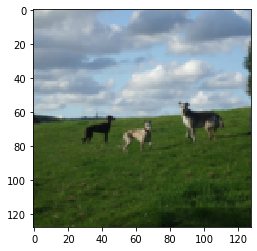

<START> a man in a red shirt is standing on a bench <END>


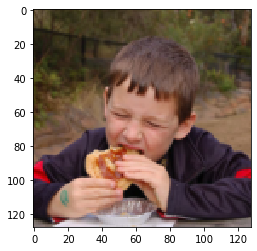

<START> a man in a red shirt is standing on a bench <END>


02/04/2021 09:18:04 - src.trainer - INFO - Epoch 4 - train_loss: 3.1698
02/04/2021 09:18:11 - src.trainer - INFO - Epoch 4 - eval_loss: 5.7834 - accuracy: 0.1152


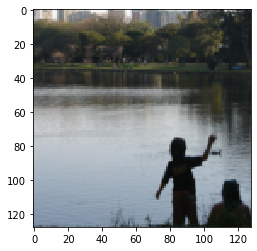

<START> a man is sitting on a bench <END>


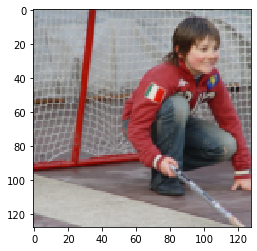

<START> a man in a red shirt is sitting on a bench <END>


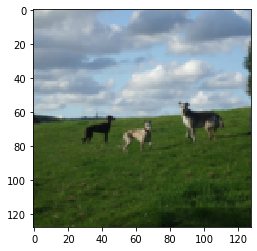

<START> a man is riding a bike on a beach <END>


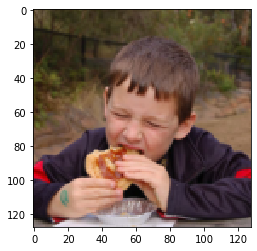

<START> a woman in a red shirt is sitting on a bench <END>


02/04/2021 09:18:53 - src.trainer - INFO - Epoch 5 - train_loss: 3.0626
02/04/2021 09:18:59 - src.trainer - INFO - Epoch 5 - eval_loss: 5.9014 - accuracy: 0.1180


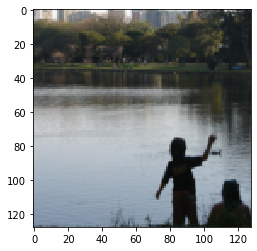

<START> a man in a blue shirt is standing on a rock <END>


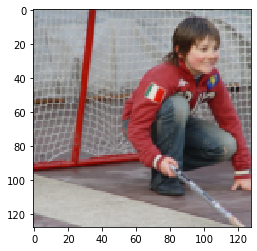

<START> a man in a red shirt is standing on a bench <END>


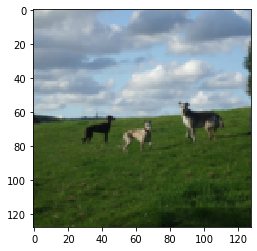

<START> a man in a blue shirt is standing on a rock <END>


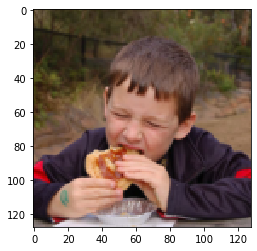

<START> a woman in a red shirt is standing on a bench <END>


02/04/2021 09:19:41 - src.trainer - INFO - Epoch 6 - train_loss: 2.9909
02/04/2021 09:19:48 - src.trainer - INFO - Epoch 6 - eval_loss: 6.0982 - accuracy: 0.1122


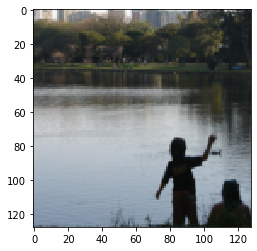

<START> a man in a blue shirt is walking on a dirt road <END>


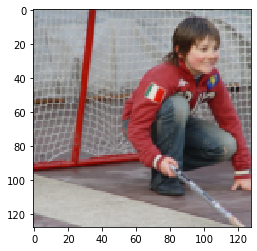

<START> a man in a blue shirt and a blue shirt is sitting on a bench <END>


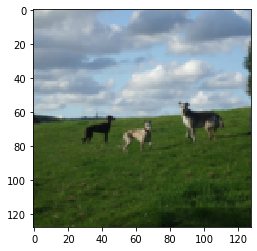

<START> a man is riding a bike on a dirt road <END>


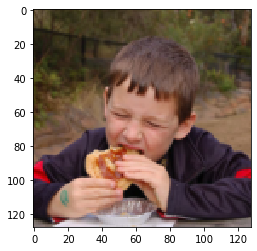

<START> a man in a blue shirt and a blue shirt is holding a sign <END>


02/04/2021 09:20:30 - src.trainer - INFO - Epoch 7 - train_loss: 2.9088
02/04/2021 09:20:36 - src.trainer - INFO - Epoch 7 - eval_loss: 6.0362 - accuracy: 0.1186


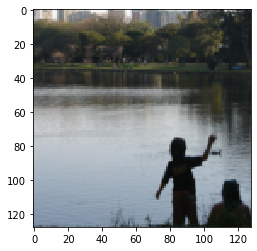

<START> a man in a red shirt is standing on a rock <END>


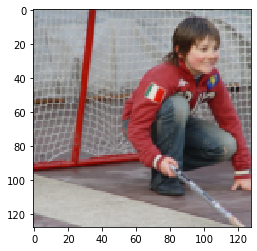

<START> a man in a red shirt is standing on a bench <END>


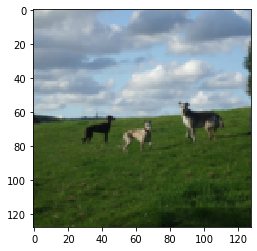

<START> a man is standing on a beach <END>


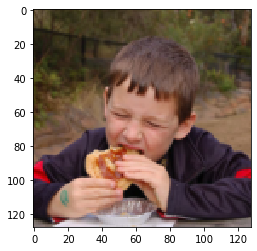

<START> a woman in a red shirt is standing on a bench <END>


02/04/2021 09:21:20 - src.trainer - INFO - Epoch 8 - train_loss: 2.8654
02/04/2021 09:21:26 - src.trainer - INFO - Epoch 8 - eval_loss: 5.9004 - accuracy: 0.1181


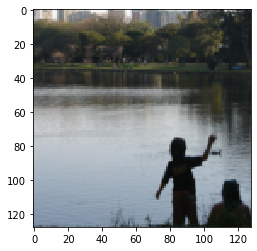

<START> a man is standing on a rock face <END>


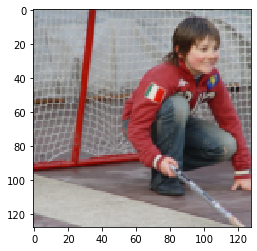

<START> a man in a red shirt is standing on a swing <END>


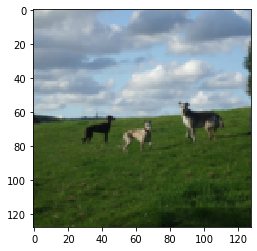

<START> a man is standing on a rock <END>


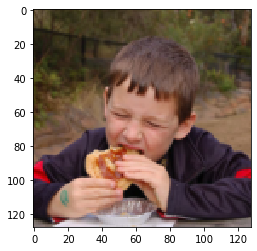

<START> a woman in a red shirt is standing on a bench <END>


02/04/2021 09:22:11 - src.trainer - INFO - Epoch 9 - train_loss: 2.7935
02/04/2021 09:22:17 - src.trainer - INFO - Epoch 9 - eval_loss: 6.1415 - accuracy: 0.1167


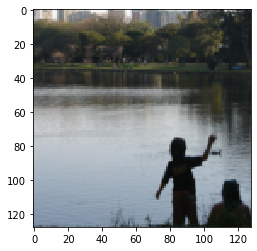

<START> a man is standing on a rock <END>


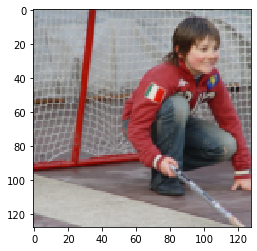

<START> a man in a black shirt and a black shirt is standing in front of a large building <END>


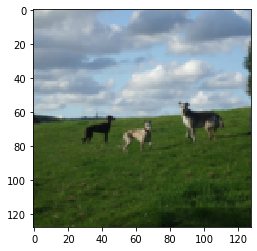

<START> a man is standing on a rock <END>


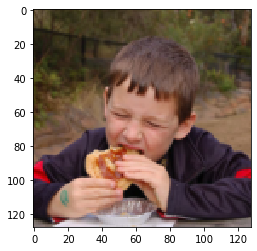

<START> a man in a black shirt and a black shirt is standing in front of a large crowd <END>


02/04/2021 09:23:01 - src.trainer - INFO - Epoch 10 - train_loss: 2.7526
02/04/2021 09:23:09 - src.trainer - INFO - Epoch 10 - eval_loss: 6.1539 - accuracy: 0.1187


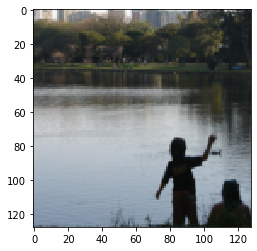

<START> a man is standing on a rock overlooking a lake <END>


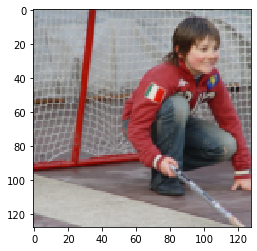

<START> a man in a red shirt is standing in front of a large crowd <END>


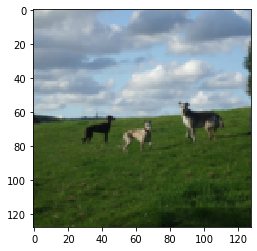

<START> a man is standing on a rock overlooking a lake <END>


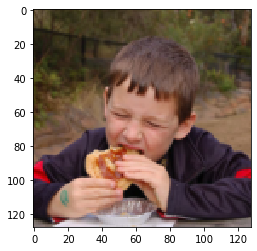

<START> a man in a red shirt is standing in front of a crowd of people <END>


02/04/2021 09:23:52 - src.trainer - INFO - Epoch 11 - train_loss: 2.7092
02/04/2021 09:23:59 - src.trainer - INFO - Epoch 11 - eval_loss: 6.1585 - accuracy: 0.1166


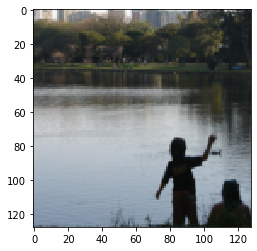

<START> a man is standing on a rock <END>


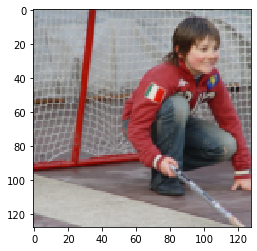

<START> a young girl in a pink shirt is jumping on a swing <END>


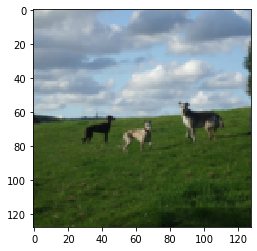

<START> a man is standing on a rock <END>


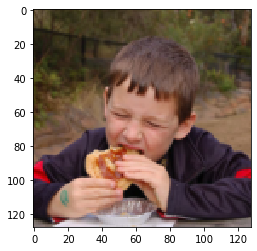

<START> a woman in a red shirt is holding a baby <END>


02/04/2021 09:24:44 - src.trainer - INFO - Epoch 12 - train_loss: 2.6706
02/04/2021 09:24:52 - src.trainer - INFO - Epoch 12 - eval_loss: 6.1480 - accuracy: 0.1215


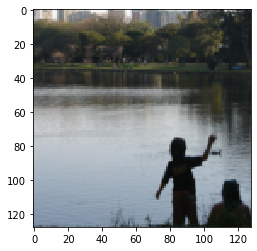

<START> a man in a red shirt is jumping into a pool <END>


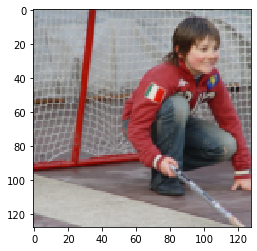

<START> a boy in a red shirt is playing with a ball <END>


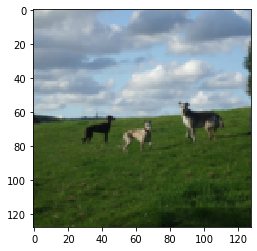

<START> a man in a red shirt is standing on a rock <END>


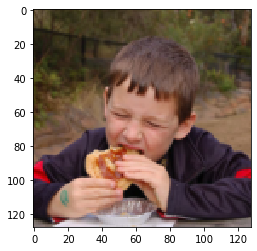

<START> a little boy is playing with a red toy <END>


02/04/2021 09:25:37 - src.trainer - INFO - Epoch 13 - train_loss: 2.6352
02/04/2021 09:25:44 - src.trainer - INFO - Epoch 13 - eval_loss: 6.3268 - accuracy: 0.1147


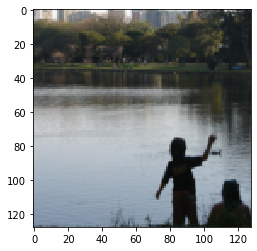

<START> a man in a blue shirt is walking on a beach <END>


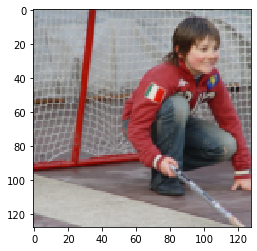

<START> a man in a red shirt is playing with a red and white dog <END>


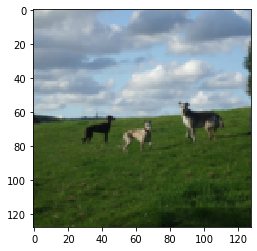

<START> a man in a white shirt and a black jacket is walking on a snowy hill <END>


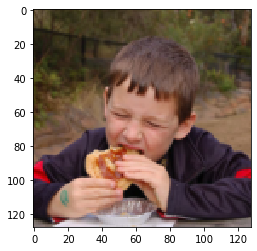

<START> a little boy in a red shirt is playing with a red toy <END>


02/04/2021 09:26:26 - src.trainer - INFO - Epoch 14 - train_loss: 2.5904
02/04/2021 09:26:34 - src.trainer - INFO - Epoch 14 - eval_loss: 6.1861 - accuracy: 0.1191


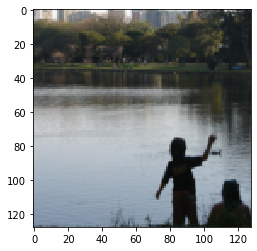

<START> a man is standing on a rock with a stick in his mouth <END>


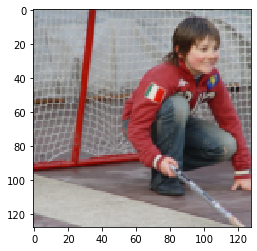

<START> a boy in a red shirt is playing with a ball <END>


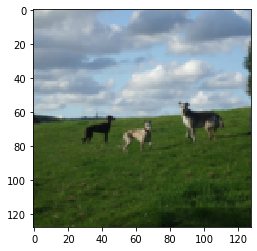

<START> a man is standing on a rock with a stick in his mouth <END>


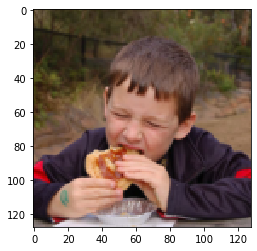

<START> a man with a red shirt and a woman in a dress <END>


02/04/2021 09:27:16 - src.trainer - INFO - Epoch 15 - train_loss: 2.5456
02/04/2021 09:27:23 - src.trainer - INFO - Epoch 15 - eval_loss: 6.2038 - accuracy: 0.1216


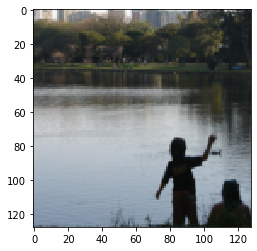

<START> a man is standing on a rock face <END>


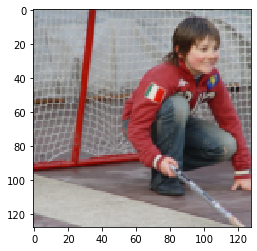

<START> a boy in a red shirt is jumping on a trampoline <END>


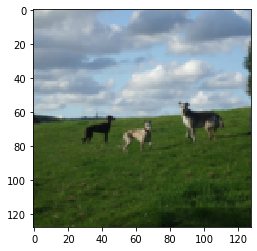

<START> a man is standing on a rock face <END>


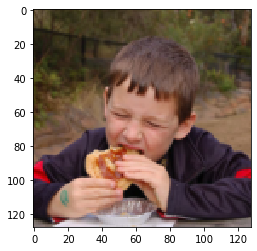

<START> a man in a red shirt is holding a baby in a park <END>


02/04/2021 09:28:07 - src.trainer - INFO - Epoch 16 - train_loss: 2.5099
02/04/2021 09:28:15 - src.trainer - INFO - Epoch 16 - eval_loss: 6.2005 - accuracy: 0.1194


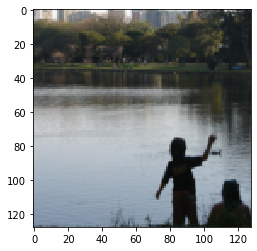

<START> a man is standing on a rock overlooking a lake <END>


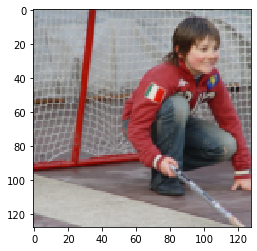

<START> a boy in a red shirt is jumping on a trampoline <END>


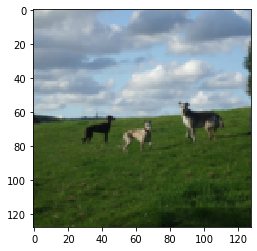

<START> a man is standing on a rock overlooking a lake <END>


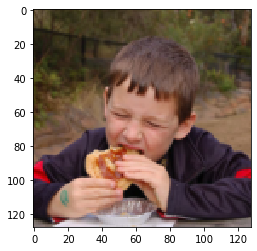

<START> a woman in a black shirt is standing in front of a building <END>


02/04/2021 09:28:57 - src.trainer - INFO - Epoch 17 - train_loss: 2.4853
02/04/2021 09:29:04 - src.trainer - INFO - Epoch 17 - eval_loss: 6.3488 - accuracy: 0.1195


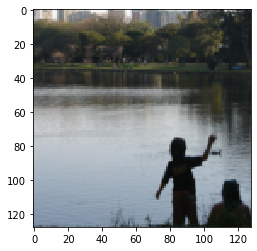

<START> a man in a red shirt is standing on a rock overlooking a valley <END>


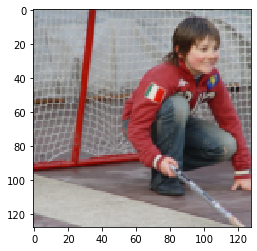

<START> a boy in a red shirt is jumping on a trampoline <END>


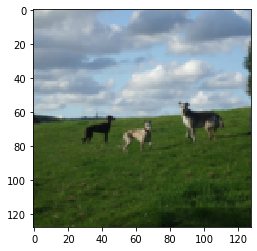

<START> a man in a white shirt and a white shirt is standing on a rock <END>


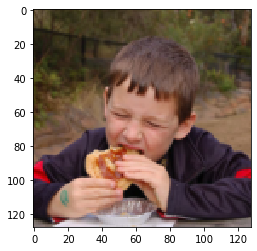

<START> a boy in a red shirt is playing with a guitar <END>


02/04/2021 09:29:46 - src.trainer - INFO - Epoch 18 - train_loss: 2.4557
02/04/2021 09:29:53 - src.trainer - INFO - Epoch 18 - eval_loss: 6.3224 - accuracy: 0.1189


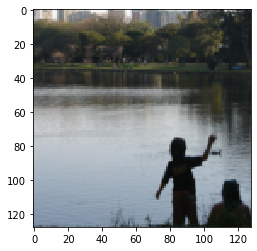

<START> a man is standing on a rock overlooking a valley <END>


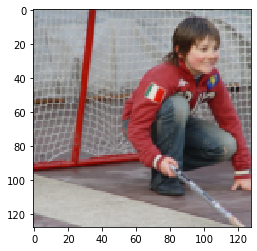

<START> a boy in a red shirt and blue shorts is jumping over a red wall <END>


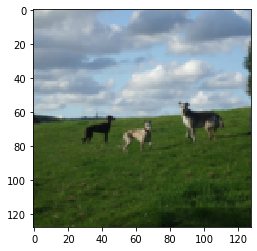

<START> a dog running through the snow <END>


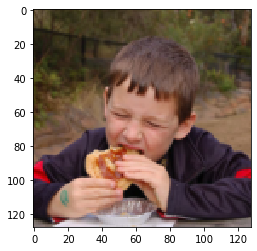

<START> a woman in a red shirt and black pants is sitting on a bench <END>


02/04/2021 09:30:35 - src.trainer - INFO - Epoch 19 - train_loss: 2.4186
02/04/2021 09:30:42 - src.trainer - INFO - Epoch 19 - eval_loss: 6.3735 - accuracy: 0.1214


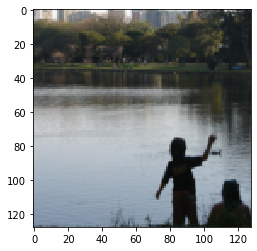

<START> a man in a blue shirt is standing on a rock overlooking a lake <END>


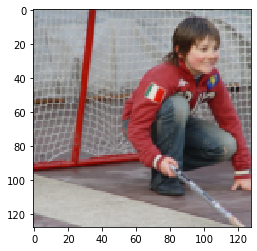

<START> a boy in a red shirt is jumping over a hurdle <END>


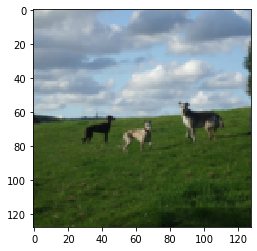

<START> a man in a white shirt and black pants is climbing a rock wall <END>


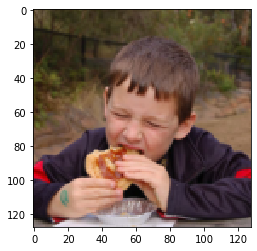

<START> a little girl in a pink shirt is standing in front of a white building <END>


In [36]:
trainer.train()

01/04/2021 21:42:27 - src.trainer - INFO - Epoch 0 - train_loss: 4.5602
01/04/2021 21:42:34 - src.trainer - INFO - Epoch 0 - eval_loss: 5.3800 - accuracy: 0.1128


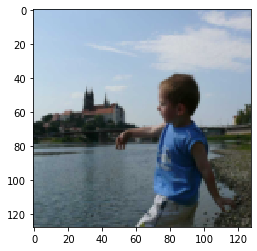

<START> a man in a black and white dog is running through the snow <END>


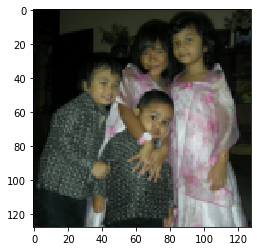

<START> a man in a black and white dog is running through the snow <END>


01/04/2021 21:43:17 - src.trainer - INFO - Epoch 1 - train_loss: 3.3442
01/04/2021 21:43:24 - src.trainer - INFO - Epoch 1 - eval_loss: 5.5997 - accuracy: 0.1248


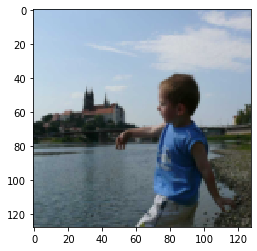

<START> a man in a red shirt is standing on a skateboard <END>


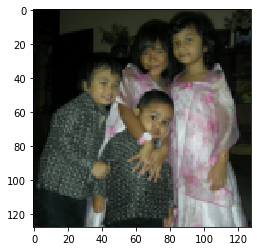

<START> a man in a red shirt is standing on a skateboard <END>


01/04/2021 21:44:06 - src.trainer - INFO - Epoch 2 - train_loss: 3.0229
01/04/2021 21:44:13 - src.trainer - INFO - Epoch 2 - eval_loss: 5.9064 - accuracy: 0.1244


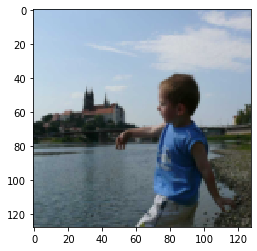

<START> a man in a red shirt is standing on a rock <END>


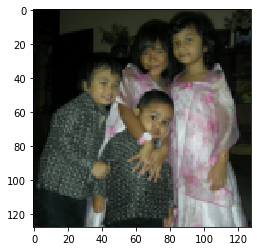

<START> a boy in a red shirt is standing on a rock <END>


01/04/2021 21:44:57 - src.trainer - INFO - Epoch 3 - train_loss: 2.7940
01/04/2021 21:45:04 - src.trainer - INFO - Epoch 3 - eval_loss: 6.3874 - accuracy: 0.1141


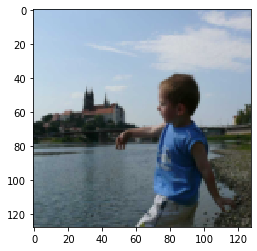

<START> a man in a red shirt and a woman in a blue shirt and a woman in a blue shirt and a woman in a blue shirt and a 


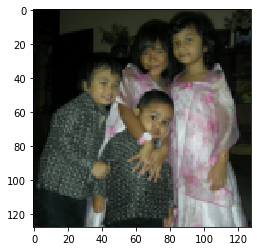

<START> a man in a red shirt and a woman in a blue shirt and a woman in a blue shirt and a woman in a blue shirt and a 


01/04/2021 21:45:47 - src.trainer - INFO - Epoch 4 - train_loss: 2.6044
01/04/2021 21:45:54 - src.trainer - INFO - Epoch 4 - eval_loss: 6.3615 - accuracy: 0.1232


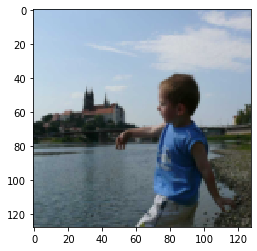

<START> a man in a red shirt is standing in front of a building <END>


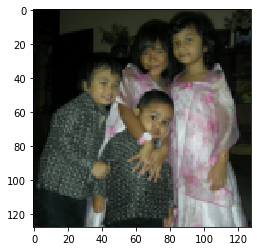

<START> a girl in a red shirt is sitting on a bench <END>


01/04/2021 21:46:39 - src.trainer - INFO - Epoch 5 - train_loss: 2.4314
01/04/2021 21:46:46 - src.trainer - INFO - Epoch 5 - eval_loss: 6.5266 - accuracy: 0.1210


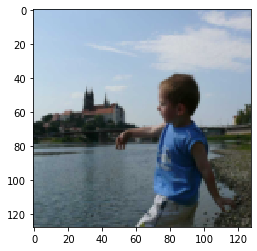

<START> a boy in a red shirt is looking at the camera <END>


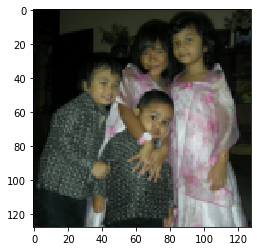

<START> a boy in a red shirt is looking at the camera <END>


01/04/2021 21:47:29 - src.trainer - INFO - Epoch 6 - train_loss: 2.2701
01/04/2021 21:47:36 - src.trainer - INFO - Epoch 6 - eval_loss: 6.6052 - accuracy: 0.1265


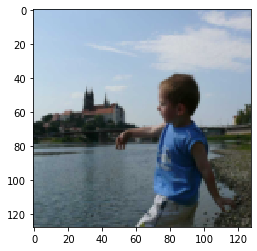

<START> a boy in a blue shirt is walking through a field of snow <END>


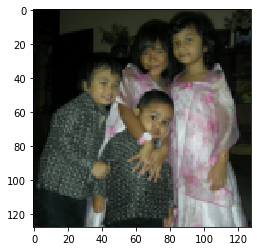

<START> a girl in a red shirt is sitting on a bench <END>


01/04/2021 21:48:19 - src.trainer - INFO - Epoch 7 - train_loss: 2.1120
01/04/2021 21:48:25 - src.trainer - INFO - Epoch 7 - eval_loss: 6.7531 - accuracy: 0.1267


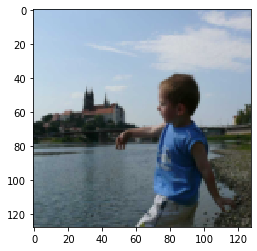

<START> a boy in a red shirt is jumping on a skateboard <END>


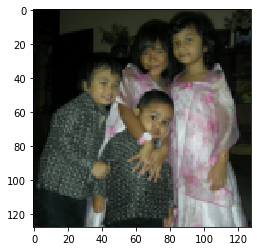

<START> a girl in a pink dress is playing with a blue and yellow ball <END>


01/04/2021 21:49:08 - src.trainer - INFO - Epoch 8 - train_loss: 1.9636
01/04/2021 21:49:14 - src.trainer - INFO - Epoch 8 - eval_loss: 7.0302 - accuracy: 0.1246


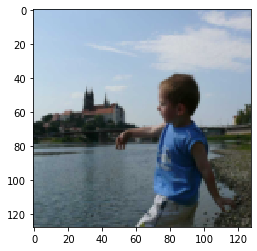

<START> a boy in a blue shirt is standing in front of a large wooden door <END>


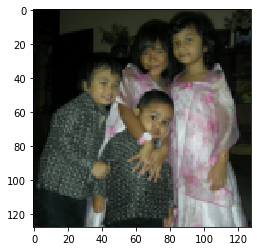

<START> a girl in a pink shirt is looking at the camera <END>


01/04/2021 21:49:57 - src.trainer - INFO - Epoch 9 - train_loss: 1.8172
01/04/2021 21:50:04 - src.trainer - INFO - Epoch 9 - eval_loss: 7.0883 - accuracy: 0.1221


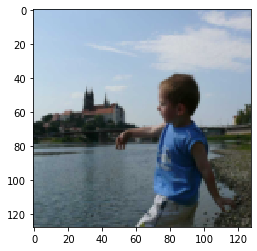

<START> a man in a red shirt and a black shirt is sitting on a rock next to a tree <END>


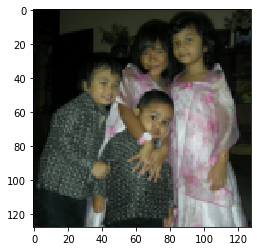

<START> a girl in a pink shirt is sitting on a bench in front of a building <END>


In [95]:
trainer.train()

### Sample some predictions

In [39]:
from src.utils import imshow

In [70]:
from torchtext.data.metrics import bleu_score

bleu_score(sampled_ids[:len(caption)], caption)

TypeError: object of type 'int' has no len()

<START> a man helping a boy ride a bicycle <END>
<START> a man helping a boy ride a bicycle <END>


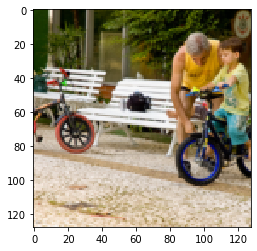

In [59]:
sampled_ids, caption = predict_img(0)
print(ds_train.decode_caption(caption))
print(ds_train.decode_caption(sampled_ids))

<START> a boy holding a <UNKNOWN> jumps in the middle of the street <END>
<START> a boy holding a <UNKNOWN> jumps in the middle of the street <END>


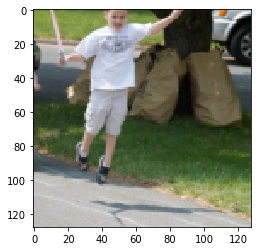

In [109]:
sampled_ids, caption = predict_img(0)
print(ds_train.decode_caption(caption))
print(ds_train.decode_caption(sampled_ids))

<START> a man in a beige shirt is operating a video camera next to a girl in a black sweater <END>
<START> a man in a beige shirt is operating a video camera next to a girl in a black sweater <END>


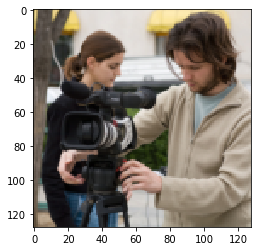

In [110]:
sampled_ids, caption = predict_img(1)
print(ds_train.decode_caption(caption))
print(ds_train.decode_caption(sampled_ids))

<START> a dog chews on a toy on a blue blanket <END>
<START> a dog chews on a toy on a blue blanket <END>


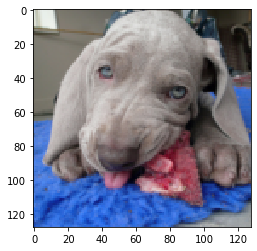

In [111]:
sampled_ids, caption = predict_img(2)
print(ds_train.decode_caption(caption))
print(ds_train.decode_caption(sampled_ids))

In [1]:
trainer.losses['eval']

NameError: name 'trainer' is not defined

In [73]:
# Plot the gradients over time
# plt.plot(trainer.grad_norms)
# plt.show()